In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab.patches import cv2_imshow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
cap = cv2.VideoCapture('/content/drive/MyDrive/Material_TPs/TP2/focus_video.mov')
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

In [31]:
def sharpness_FM(img):
    """
    Calcula el índice FM para una imagen en escala de grises:
      FM = (# de coeficientes de Fourier con magnitud > max/1000) / (total píxeles)
    """
    # 3.1 FFT y centrado
    F = np.fft.fft2(img)
    Fc = np.fft.fftshift(F)
    AF = np.abs(Fc)
    # 3.2 Umbral
    M = AF.max()
    thresh = M / 1000.0
    # 3.3 Conteo y normalización
    high_count = np.sum(AF > thresh)
    return high_count / img.size

# Extraemos el ROI centrado en base a un area porcentual
def crop_center(img, area_frac):
    """
    Recorta un ROI cuadrado centrado cuya área es area_frac del área total.
    """
    H, W = img.shape
    side = int(np.sqrt(area_frac) * min(H, W))
    y0 = (H - side) // 2
    x0 = (W - side) // 2
    return img[y0:y0+side, x0:x0+side]


Procesando frames: 100%|██████████| 171/171 [00:03<00:00, 47.90it/s]


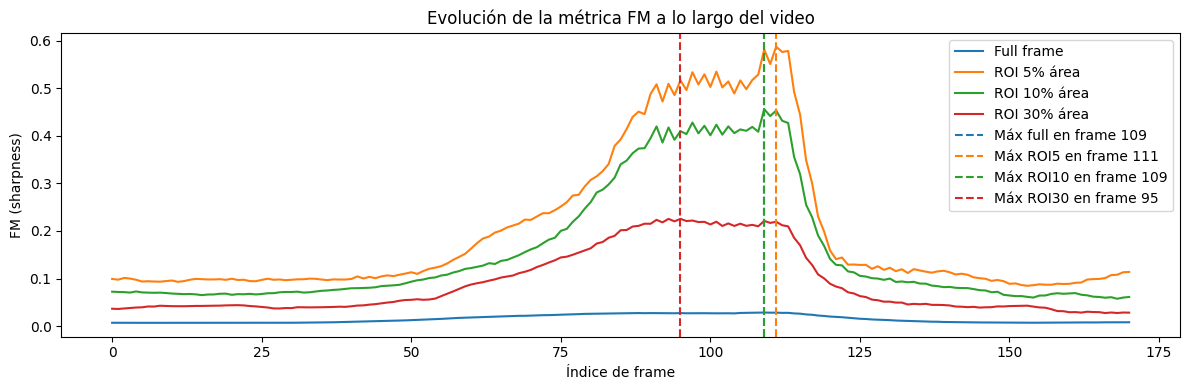

In [33]:
# Hacemos pruebas
fm_full   = np.zeros(n_frames, dtype=np.float32)
fm_roi05  = np.zeros(n_frames, dtype=np.float32)
fm_roi10  = np.zeros(n_frames, dtype=np.float32)
fm_roi30  = np.zeros(n_frames, dtype=np.float32)

for i in tqdm(range(n_frames), desc='Procesando frames'):
    ret, frame = cap.read()
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # experimento 1: todo el frame
    fm_full[i]  = sharpness_FM(gray)
    # experimento 2: ROI 5%
    roi5  = crop_center(gray, 0.05)
    fm_roi05[i] = sharpness_FM(roi5)
    # experimento 3: ROI 10%
    roi10 = crop_center(gray, 0.10)
    fm_roi10[i] = sharpness_FM(roi10)
    # experimento 4: ROI 15%
    roi30 = crop_center(gray, 0.30)
    fm_roi30[i] = sharpness_FM(roi30)

cap.release()


plt.figure(figsize=(12, 4))
plt.plot(fm_full,  label='Full frame')
plt.plot(fm_roi05, label='ROI 5% área')
plt.plot(fm_roi10, label='ROI 10% área')
plt.plot(fm_roi30, label='ROI 30% área')
plt.axvline(np.argmax(fm_full), color='C0', ls='--',
            label=f'Máx full en frame {np.argmax(fm_full)}')
plt.axvline(np.argmax(fm_roi05), color='C1', ls='--',
            label=f'Máx ROI5 en frame {np.argmax(fm_roi05)}')
plt.axvline(np.argmax(fm_roi10), color='C2', ls='--',
            label=f'Máx ROI10 en frame {np.argmax(fm_roi10)}')
plt.axvline(np.argmax(fm_roi30), color='C3', ls='--',
            label=f'Máx ROI30 en frame {np.argmax(fm_roi30)}')
plt.xlabel('Índice de frame')
plt.ylabel('FM (sharpness)')
plt.title('Evolución de la métrica FM a lo largo del video')
plt.legend()
plt.tight_layout()
plt.show()

--- Full Frame @ frame 109 ---


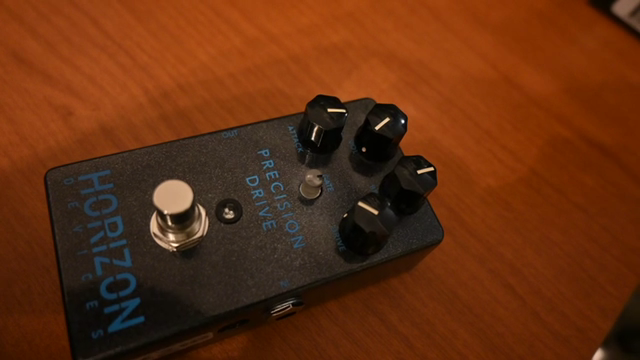

--- ROI 5% @ frame 111 ---


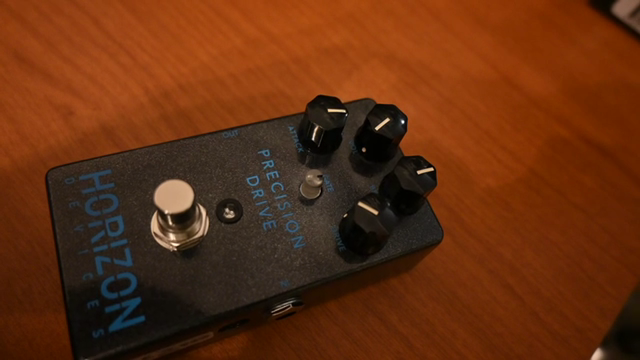

--- ROI 10% @ frame 109 ---


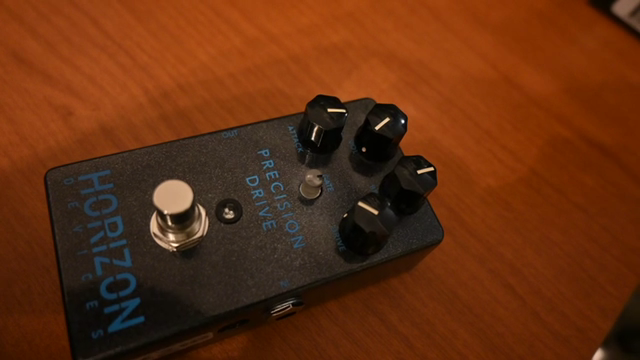

--- ROI 30% @ frame 95 ---


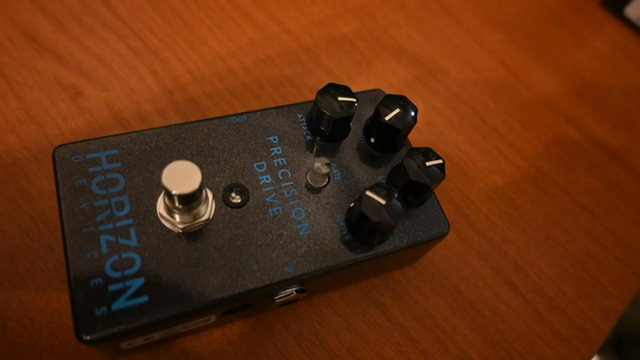

In [34]:
# Visualizamos los frames donde estan los picos maximos de cada uno
cap = cv2.VideoCapture('/content/drive/MyDrive/Material_TPs/TP2/focus_video.mov')
f_full = int(np.argmax(fm_full))
f_r5   = int(np.argmax(fm_roi05))
f_r10  = int(np.argmax(fm_roi10))
f_r30  = int(np.argmax(fm_roi30))
for name, fidx in [('Full Frame', f_full), ('ROI 5%', f_r5), ('ROI 10%', f_r10), ('ROI 30%', f_r30)]:
    cap.set(cv2.CAP_PROP_POS_FRAMES, fidx)
    ret, frm = cap.read()
    if not ret: continue
    print(f"--- {name} @ frame {fidx} ---")
    cv2_imshow(frm)
cap.release()

Podemos ver que para el ROI 5% y 10% alcanzan su pico muy cerca (frames 111 y 109 respectivamente) y el ROI 30% que pusimos de prueba lo marca en el frame 95. Con lo cual podemos decir que con un ROI muy chico como 5% este tiende a ser mas sensible al ruido y texturas chicas, mientras que para un ROI muy grande como 30%, este tiende a incluir partes mas desenfocadas, y esto hace que el maximo se encuentre antes. Ademas, el frame maximo para el Full Frame y ROI 10% es exactamente el mismo.

Ante esto podemos ver que por ahi para hacer un detector mas robusto, nos convenga un ROI entre 8% y 12% del area, o incluso hacerlo dinamico, es decir, adaptar dinamicamente el tamaño segun la textura, mas chico cuando hay mas detalle, mas grande cuando es mas homogeneo todo.